<a href="https://colab.research.google.com/github/poisonkissedsk/Production-Grade-AI-QA-Suite/blob/main/XAI_Explanation_Stability_%26_Faithfulness_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-1-491527964.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numeric] = StandardScaler().fit_transform(X[numeric])



[STABILITY TEST] Same Candidate, Multiple Runs
Run 0 vs Run 1: Cosine Similarity = 1.0000, Spearman Correlation = 1.0000
Run 0 vs Run 2: Cosine Similarity = 1.0000, Spearman Correlation = 1.0000
Run 0 vs Run 3: Cosine Similarity = 1.0000, Spearman Correlation = 1.0000
Run 0 vs Run 4: Cosine Similarity = 1.0000, Spearman Correlation = 1.0000

[CONTRASTIVE TEST] Original vs Perturbed Candidate
Cosine Similarity = 0.9933
Spearman Correlation = 0.9560


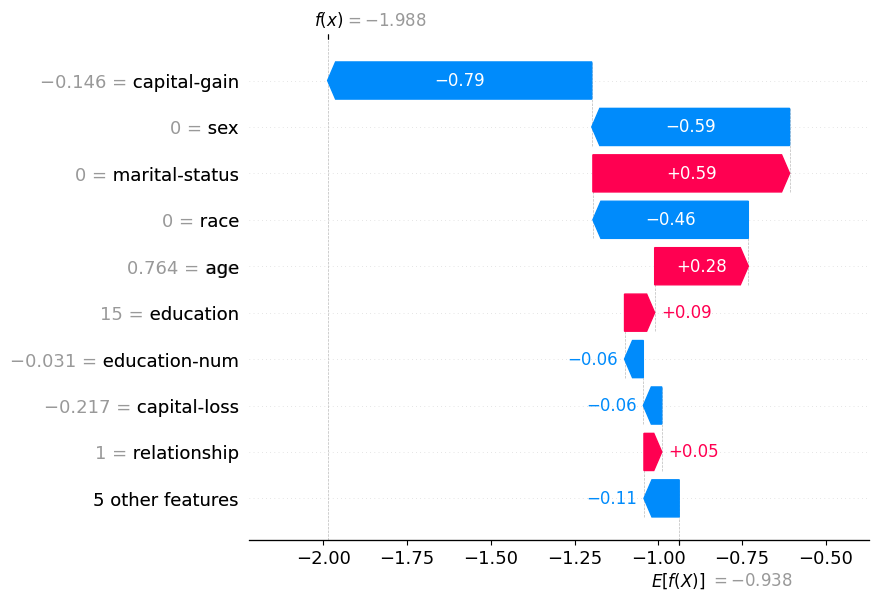

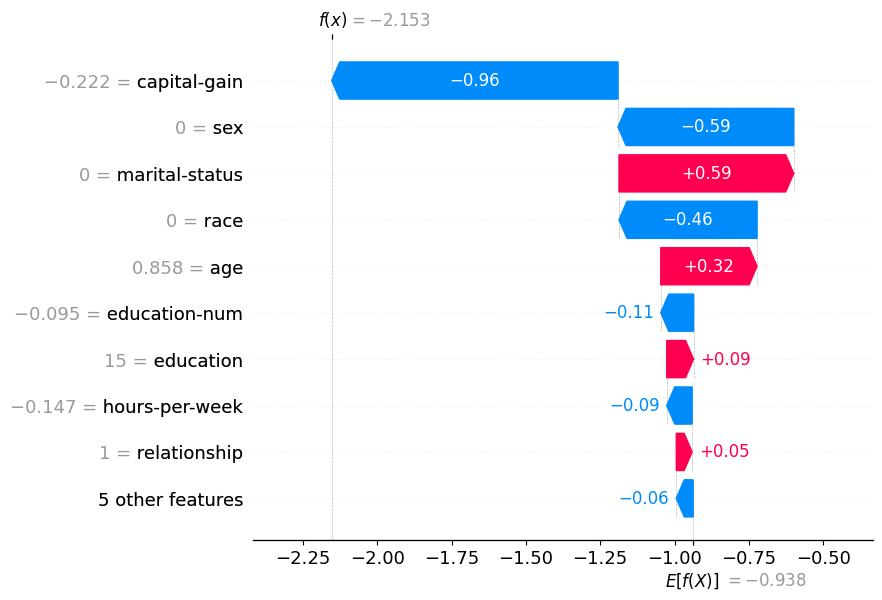

In [1]:
# 📒 Notebook 7: XAI Explanation Stability & Faithfulness Testing (Google Colab)

# -- SETUP --
!pip install shap scikit-learn pandas numpy scipy --quiet

import shap
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.spatial.distance import cosine
from scipy.stats import spearmanr

# -- STEP 1: Load Data & Train Model --

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]

df = pd.read_csv(url, names=columns, na_values=' ?', skipinitialspace=True)
df.dropna(inplace=True)
df['label'] = (df['income'] == '>50K').astype(int)

categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numeric = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

for col in categorical:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df[categorical + numeric]
y = df['label']

X[numeric] = StandardScaler().fit_transform(X[numeric])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# -- STEP 2: Pick a Candidate and Run SHAP Multiple Times (Stability Test) --

candidate = X_test.iloc[[0]]
shap_explanations = []

for i in range(5):
    explainer = shap.Explainer(model, X_test)
    shap_values = explainer(candidate)
    shap_explanations.append(shap_values.values[0])

# Compare explanations: Cosine Similarity and Spearman Correlation
print("\n[STABILITY TEST] Same Candidate, Multiple Runs")

for i in range(1, 5):
    cos_sim = 1 - cosine(shap_explanations[0], shap_explanations[i])
    rho, _ = spearmanr(shap_explanations[0], shap_explanations[i])
    print(f"Run 0 vs Run {i}: Cosine Similarity = {cos_sim:.4f}, Spearman Correlation = {rho:.4f}")

# -- STEP 3: Contrastive Explanation Test --

perturbed_candidate = candidate.copy()
perturbed_candidate[numeric] += np.random.normal(0, 0.1, perturbed_candidate[numeric].shape)

shap_values_original = shap.Explainer(model, X_test)(candidate).values[0]
shap_values_perturbed = shap.Explainer(model, X_test)(perturbed_candidate).values[0]

cos_sim_contrast = 1 - cosine(shap_values_original, shap_values_perturbed)
rho_contrast, _ = spearmanr(shap_values_original, shap_values_perturbed)

print("\n[CONTRASTIVE TEST] Original vs Perturbed Candidate")
print(f"Cosine Similarity = {cos_sim_contrast:.4f}")
print(f"Spearman Correlation = {rho_contrast:.4f}")

# -- STEP 4: Visualize Explanations --

shap.plots.waterfall(shap.Explainer(model, X_test)(candidate)[0])
shap.plots.waterfall(shap.Explainer(model, X_test)(perturbed_candidate)[0])
